# 基本信息


| 班级   | 姓名 | 学号 |
| :------- | ------ | ------ |
| SSSSSS | AA   | 2222 |
|        | BB   | 333  |

# 任务： 网络中心性的度量与解释（电视剧主演）

1. 构建“小组偏爱的演员网络”。根据组员的偏好，爬取豆瓣上不少于200部评分不低于7分的中国（含香港、澳门、台湾）电视剧的“主演”信息。凡出演同一部电视剧的演员之间，建立一条连边。连边上的权重代表演员之间的合作（即：共同出演同一部剧的）次数。

2. 构建“官方偏爱的演员网络”，根据中国电视剧三大奖项：飞天奖、金鹰奖、白玉兰奖的获奖名单，从豆瓣爬取名单上不少于200部电视剧的“主演”信息。凡主演。。。同上。

3. 用python绘制出上述两个演员合作网（有权图）
4. 计算两个网络中，各节点的四种中心性（点度中心性，中介中心性，接近中心性，特征向量中心性），并排序、输出各结果中排在前30的演员名单极其排序。同时，解读每种中心性结果的现实意义，并比较两个网络中共同出现的演员在不同网络中，各中心性指标的得分差异【提示：跨网络比较，请使用标准化的XX中心得分】。

5. 针对每种中心性度量中得分最高的5个节点，写一个循环，每次去掉一个当前得分最高的节点并输出节点排序情况。观察网络中，各节点XX中心性的排序变化情况，并在此基础上，加深理解各中心指标与网络结构之间的关系。


# 任务要求

1. 所有任务均需要提交至少两个文件：
    1. 数据
    2. 以Jupyter notebook提交的代码及全部运行结果。

2. 文件的第一部分，请以markdown模式，标注班级、组员的姓名和学号。
3. 文件的第二部分，请以markdown模式放置老师布置的任务描述。
4. 文件的第三部分，请以markdown模式，阐述任务代码的编写思路（如：1.建立一个列表/字典/元祖，存入节点对之间的指向关系；2.利用XX函数，将列表/字典/元祖转化为矩阵a；3.利用XX包的XX函数，计算矩阵a的转置矩阵，并存储为矩阵b；4. ...
5. 文件的第四部分，放置代码，并在一段代码块之前后之后，记得添加comment，说明每段代码的意图做什么【注：老师在阅读你们的代码过程中，如因缺乏注释而有不理解的地方，可能会请你们当面解释代码，再决定如何打分。】。
6. 评分标准：能正确使用markdown（第一、第二部分），思路清晰且详尽（第三部分），代码跑得通（第四部分），结果正确且解读正确（第四部分，部分作用需要解读结果，那么，请在代码后面，以Markdown模式，加入对结果的解读）

# 思路



###  数据收集

1. 利用豆瓣接口采集评分不低于的“国产剧”和“港剧”，不少于200部的电视剧列表。主要采集信息包括电视剧ID, 评分，并按照评分过滤出不低于7分的目标。
2. 利用百度百科等网站人工收集白玉兰奖、飞天奖、金鹰奖等往届获奖电视剧名称。
3. 利用豆瓣电影搜索功能，根据上述所收集的电视剧名称，采集电视剧对应的电视剧ID。
4. 上述两类电视剧信息保存到文件中，供之后使用。
2. 通过电视剧ID爬取到每部电视剧的主演信息，并保存。
    1. 演员的id到姓名的映射信息。
    2. 保存电视剧ID到演员ID列表的映射信息。


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import quote, unquote


In [27]:
# param definitions

# ！！！注意
# 1.爬虫的时候需要设置自己的cookie,否则会因为反爬虫等限制请求失败
# 2.cookie是标识个人身份的数据，请严密保管自己的登录cookie
# 3.cookie需要通过在网页登录账号后，通过开发者工具获取
cookie = '''bid=WKVIFxu-_BI; ll="108169"; _pk_id.100001.4cf6=13f66ba9365007aa.1702169933.; __yadk_uid=1uTdv3YY9bVVs7gJfbnKDrz3Z4HLs8iD; trc_cookie_storage=taboola%2520global%253Auser-id%3D1613af5e-5a4a-4430-aadc-3695ac79e22a-tuctbef1e6b; _vwo_uuid_v2=DEFD34520150EA3FE9E06EC61307F84DD|58296990af6614d764b0f4a201fd125f; _ga=GA1.1.191779183.1701751376; _cc_id=23b54b9d3ef3a33a34eac66eed7b4a6a; panoramaId_expiry=1702776749037; panoramaId=f1310b00fced7a55f575e1c2e5e316d539385cb9e22ad6923b1d93788d069ada; panoramaIdType=panoIndiv; cto_bundle=BXoJSV91eU5RTFdCSmcxTFh6ZzJ4M3VUSFVkalFicWVrSGZKNkF0SEJKamlRc0lnY0huQzBRTEdRbmVkTm9sdVFIVThqMTVoanNrJTJCYzlRUUhLZEtSbFZNWVNSV1lJV3NHME9JUzVzQjJhWHhubldVbTQlMkJHcVVZeEluaHB1eFJSU2FXYWs1JTJGcWJWT0NNNjJnMTZCVVVXYmg3bERDOE5mVEN5MzN6ZTVEckt0N3Y1WGRQUmQ2JTJGa2xWMGU0b1V3ZDNzbHZ5OEpEQXpTVXZpaWJ5RThiMXZuQ1MybFElM0QlM0Q; _ga_YD7QXHZJ4Y=GS1.1.1702171947.1.1.1702172062.0.0.0; _ga_Y4GN1R87RG=GS1.1.1702171948.3.1.1702172062.0.0.0; __utmc=30149280; dbcl2="65813696:ATM4RixqcdE"; ck=Bp8_; push_noty_num=0; push_doumail_num=0; __utmv=30149280.6581; __utmc=223695111; frodotk_db="fe56a24c69638f87fb03e6e53c2aae95"; __utmz=223695111.1702391062.8.4.utmcsr=localhost:8888|utmccn=(referral)|utmcmd=referral|utmcct=/; ap_v=0,6.0; __utma=30149280.191779183.1701751376.1702391062.1702415342.10; __utmz=30149280.1702415342.10.5.utmcsr=movie.douban.com|utmccn=(referral)|utmcmd=referral|utmcct=/subject/2284418/; _pk_ref.100001.4cf6=%5B%22%22%2C%22%22%2C1702415855%2C%22http%3A%2F%2Flocalhost%3A8888%2F%22%5D; _pk_ses.100001.4cf6=1; __utma=223695111.191779183.1701751376.1702391062.1702415855.9; __utmb=223695111.0.10.1702415855; __gads=ID=a9b321e888688167:T=1702171894:RT=1702417508:S=ALNI_MbJAOSJsVQBSYsoHKK1YgOhrt4-vg; __gpi=UID=00000ca895d8a964:T=1702171894:RT=1702417508:S=ALNI_MY587WTpStdnaM_AGYG1dCqa678-w; __utmt=1; __utmb=30149280.6.10.1702415342'''

headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Sec-Ch-Ua": '''"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"''',
    "Referer": "https://movie.douban.com/",
    "Sec-Fetch-Dest": "document",
    "cookie": cookie,
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

GUOCHANJUAN_TAG = "国产剧"
GANGJU_TAG = "港剧"
REWARD_TAG = "三大电视奖"

GROUP_LIKE_LABEL = 'group_like'
OFFICIAL_LIKE_LABEL = 'official_like'

# input
REWARD_TV_FILE = "data/reward_tv_titles.csv"

GET_DOUBAN_TV_TAG_URL = "https://movie.douban.com/j/search_subjects"
SEARCH_TV_URL = "https://www.douban.com/search?cat=1002&q="
GET_ACTOR_URL = f"https://movie.douban.com/subject/"
ACTOR_DETAIL_URL = "https://movie.douban.com/celebrity/"

# output
TV_LOOKUP_FILE = "data/tv_list.csv" # id->title
ACTOR_LOOKUP_FILE = "data/actor_list.csv" # id->name
TV_ACTORS_FILE = "data/tv_actor_list.csv"

In [30]:
# function definitions

def get_douban_tv_by_tag(tag, num = 1):
    url = GET_DOUBAN_TV_TAG_URL
    params = {
        "type": "tv",
        "tag": tag,
        "page_limit": num,  # You can adjust the limit as needed
        "page_start": 0
    }
    response = requests.get(url, params=params, headers = headers)
    dramas = response.json().get('subjects', [])

    filtered_dramas = []
    for drama in dramas:
        title = drama["title"]
        url = drama["url"].strip('/')
        rate = drama["rate"]
        if rate == '' or float(rate) < 7:
            continue
        did = drama["id"]
        filtered_dramas.append([tag, did, title, rate, url])
        if len(filtered_dramas) % 5 == 0:
            print(f"get_douban_tv_by_tag for {tag}, size {len(filtered_dramas)} dramas")
    return filtered_dramas

def search_tv_by_name(search_text):
    quoted_search_text = quote(search_text)

    url = f"{SEARCH_TV_URL}{quoted_search_text}"

    # 发送请求
    r = requests.get(url, headers=headers)
    status = r.status_code
    if status == 200:
        soup = BeautifulSoup(r.content.decode('utf-8'),"html.parser",from_encoding="utf-8")
        a = soup.find('div', class_='result-list')
        if a is None:
            print(f"fail soup find for {search_text}")
            return None
        num = len(a)
        if num == 0:
            print('request succ, but null result')
        else:
            href = a.find('a', href=True)
            link = href['href'].split('?url=')[-1].split('%2F&query=')[0]
            uq_link = unquote(link).strip('/')
            return uq_link
    else:
        print(f"Request failed, code:{status}")
    return None

def get_tv_actors(tv_id):

    url = f"{GET_ACTOR_URL}{tv_id}"

    r = requests.get(url, headers=headers)
    status = r.status_code
    return_actors = []
    if status == 200:
        soup = BeautifulSoup(r.content.decode('utf-8'),"html.parser")
        a = soup.find('div', class_='subject clearfix')
        if a is not None:
            actors = a.find('span', class_='actor')
            if actors is not None:
                attrs = actors.find('span', class_='attrs')
                if attrs is not None: 
                    hrefs = attrs.find_all('a', href=True)
                    if hrefs is not None:
                        for item in hrefs:
                            aname = item.get_text()
                            aid = item['href'].strip('/')
                            return_actors.append((aname, aid))
    else:
        print(f"request failed for tv_id:{tv_id}, status:{status}")
    return return_actors

def get_reward_tv(num):
    with open(REWARD_TV_FILE, 'r') as f:
        result = []
        for line in f.readlines():
            title = line.strip()
            link = search_tv_by_name(title)
            if link is not None:
                tv_id = link.strip().strip('/').split('/')[-1]
                result.append([REWARD_TAG, tv_id, title, '10', link])
            if len(result) % 5 == 0:
                print(f"get_reward_tv size:{len(result)} dramas")
            if len(result) >= num:
                break
        return result
        
def tv_write(data, tag, label):
    
    with open(TV_LOOKUP_FILE, 'a+') as f:
        for tv in data:
            [_, tv_id, title, rate, link] = tv
            ntitle = title.replace(',', '&')
            simple_tv = [tv_id, ntitle, tag, label]
            f.write(','.join(simple_tv) + '\n')

In [31]:
# 简单地测试一下上面几个函数
ta = get_douban_tv_by_tag("国产剧", 1)
print(ta)

tb = search_tv_by_name("一念关山")
print(tb)

tc = get_tv_actors("35797771")
print(tc)


td = get_reward_tv(1)
print(td)

[['国产剧', '35797771', '一念关山', '7.3', 'https://movie.douban.com/subject/35797771']]
https://movie.douban.com/subject/35797771
[('刘诗诗', 'celebrity/1274533'), ('刘宇宁', 'celebrity/1401585'), ('方逸伦', 'celebrity/1359360'), ('何蓝逗', 'celebrity/1376538'), ('陈昊宇', 'celebrity/1351561'), ('常华森', 'celebrity/1437324'), ('王艳', 'celebrity/1274509'), ('吕行', 'celebrity/1313870'), ('李欢', 'celebrity/1349341'), ('陈宥维', 'celebrity/1386145'), ('陈都灵', 'celebrity/1342249'), ('王一哲', 'celebrity/1397908'), ('陈小纭', 'celebrity/1361294'), ('张芷溪', 'celebrity/1323727'), ('黄梦莹', 'celebrity/1349244'), ('张帆', 'celebrity/1420285'), ('叶青', 'celebrity/1315746'), ('叶筱玮', 'celebrity/1371589'), ('原若航', 'celebrity/1439518'), ('吴弘', 'celebrity/1342009'), ('张垒', 'celebrity/1276088'), ('苏梦芸', 'celebrity/1452637'), ('张乔耳', 'celebrity/1440942'), ('周陆啦', 'celebrity/1418957'), ('尹铸胜', 'celebrity/1313561'), ('张天阳', 'celebrity/1339958'), ('常铖', 'celebrity/1314524'), ('曾柯琅', 'celebrity/1424329'), ('景如洋', 'celebrity/1408694')]
[['三大电视奖', '6

In [6]:
# 爬取300部国产剧
NUM = 300
gcj_list = get_douban_tv_by_tag(GUOCHANJUAN_TAG, NUM)
gj_list = get_douban_tv_by_tag(GANGJU_TAG, NUM)

# 写电视剧id/name映射文件
tv_write(gcj_list, GUOCHANJUAN_TAG, GROUP_LIKE_LABEL)
tv_write(gj_list, GANGJU_TAG, GROUP_LIKE_LABEL)


get_douban_tv_by_tag for 国产剧, size 5 dramas
get_douban_tv_by_tag for 国产剧, size 10 dramas
get_douban_tv_by_tag for 国产剧, size 15 dramas
get_douban_tv_by_tag for 国产剧, size 20 dramas
get_douban_tv_by_tag for 国产剧, size 25 dramas
get_douban_tv_by_tag for 国产剧, size 30 dramas
get_douban_tv_by_tag for 国产剧, size 35 dramas
get_douban_tv_by_tag for 国产剧, size 40 dramas
get_douban_tv_by_tag for 国产剧, size 45 dramas
get_douban_tv_by_tag for 国产剧, size 50 dramas
get_douban_tv_by_tag for 国产剧, size 55 dramas
get_douban_tv_by_tag for 国产剧, size 60 dramas
get_douban_tv_by_tag for 国产剧, size 65 dramas
get_douban_tv_by_tag for 国产剧, size 70 dramas
get_douban_tv_by_tag for 国产剧, size 75 dramas
get_douban_tv_by_tag for 国产剧, size 80 dramas
get_douban_tv_by_tag for 国产剧, size 85 dramas
get_douban_tv_by_tag for 国产剧, size 90 dramas
get_douban_tv_by_tag for 国产剧, size 95 dramas
get_douban_tv_by_tag for 国产剧, size 100 dramas
get_douban_tv_by_tag for 国产剧, size 105 dramas
get_douban_tv_by_tag for 国产剧, size 110 dramas
get_doub

In [12]:
# 爬取获奖电视剧的ID信息
# reward_list = get_reward_tv(NUM) 
# 由于网站有反爬虫限制，爬取一次后存储结果，之后直接读取这个爬取结果，不再重复爬取
reward_list = []
REWARD_TV_LIST_FILE = "data/reward_tv_list.csv"
NUM = 200
with open(REWARD_TV_LIST_FILE, 'r') as f:
        result = []
        for line in f.readlines():
            item = line.strip().split(',')
            tv_id = item[0]
            title = item[1]
            link = item[2]
            reward_list.append([REWARD_TAG, tv_id, title, '10', link])
            if len(reward_list) % 5 == 0:
                print(f"get_reward_tv size:{len(reward_list)} dramas")
            if len(reward_list) >= NUM:
                break

tv_write(reward_list, REWARD_TAG, OFFICIAL_LIKE_LABEL)

get_reward_tv size:5 dramas
get_reward_tv size:10 dramas
get_reward_tv size:15 dramas
get_reward_tv size:20 dramas
get_reward_tv size:25 dramas
get_reward_tv size:30 dramas
get_reward_tv size:35 dramas
get_reward_tv size:40 dramas
get_reward_tv size:45 dramas
get_reward_tv size:50 dramas
get_reward_tv size:55 dramas
get_reward_tv size:60 dramas
get_reward_tv size:65 dramas
get_reward_tv size:70 dramas
get_reward_tv size:75 dramas
get_reward_tv size:80 dramas
get_reward_tv size:85 dramas
get_reward_tv size:90 dramas
get_reward_tv size:95 dramas
get_reward_tv size:100 dramas
get_reward_tv size:105 dramas
get_reward_tv size:110 dramas
get_reward_tv size:115 dramas
get_reward_tv size:120 dramas
get_reward_tv size:125 dramas
get_reward_tv size:130 dramas
get_reward_tv size:135 dramas
get_reward_tv size:140 dramas
get_reward_tv size:145 dramas
get_reward_tv size:150 dramas
get_reward_tv size:155 dramas
get_reward_tv size:160 dramas
get_reward_tv size:165 dramas
get_reward_tv size:170 dramas


In [22]:
# 汇总并去重上述电视剧
tv_id_set = set()
with open(TV_LOOKUP_FILE, 'r') as f:
    for line in f.readlines():
        item = line.strip().split(',')
        tv_id_set.add(item[0])

tv_id_list = list(tv_id_set)
print(f"总电视剧部数：{len(tv_id_list)}")

总电视剧部数：624


In [32]:
# 爬取上述电视剧的主演列表
tv2actor = {}

actor_map = {}
tv2actor_simple = {}
for tv_id in tv_id_list:
    v = get_tv_actors(tv_id)
    aid_list = []
    if len(v) == 0:
        continue
    for item in v:
        [name, aid] = item
        aid = aid.split('/')[-1]
        actor_map[aid] = name
        aid_list.append(aid)
    tv2actor_simple[tv_id] = aid_list
    if len(tv2actor_simple) % 5 == 0:
        print(f"get_tv_actors size:{len(tv2actor_simple)} dramas")

print(f"actor size: {len(actor_map)}")

get_tv_actors size:5 dramas
get_tv_actors size:10 dramas
get_tv_actors size:15 dramas
get_tv_actors size:20 dramas
get_tv_actors size:25 dramas
get_tv_actors size:30 dramas
get_tv_actors size:35 dramas
get_tv_actors size:40 dramas
get_tv_actors size:45 dramas
get_tv_actors size:50 dramas
get_tv_actors size:55 dramas
get_tv_actors size:60 dramas
get_tv_actors size:65 dramas
get_tv_actors size:70 dramas
get_tv_actors size:75 dramas
get_tv_actors size:80 dramas
get_tv_actors size:85 dramas
get_tv_actors size:90 dramas
get_tv_actors size:95 dramas
get_tv_actors size:100 dramas
get_tv_actors size:105 dramas
get_tv_actors size:110 dramas
get_tv_actors size:115 dramas
get_tv_actors size:120 dramas
get_tv_actors size:125 dramas
get_tv_actors size:130 dramas
get_tv_actors size:135 dramas
get_tv_actors size:140 dramas
get_tv_actors size:145 dramas
request failed for tv_id:20444539, status:404
get_tv_actors size:150 dramas
get_tv_actors size:155 dramas
get_tv_actors size:160 dramas
get_tv_actors 

In [33]:
# 写演员映射表
def actor_write(data):
    with open(ACTOR_LOOKUP_FILE, 'w') as f:
        for k, v in data.items():
            v = v.replace(',', '&')
            f.write(f'{k},{v}\n')
actor_write(actor_map)
        

In [34]:
# 写电视剧的演员列表
with open(TV_ACTORS_FILE, 'w') as f:
    for k, v in tv2actor_simple.items():
        v_str = ' '.join(v)
        f.write(f'{k},{v_str}\n')

In [35]:
# 读取电视剧的演员列表
tv2actor_id = {}
with open(TV_ACTORS_FILE, 'r') as f:
    for line in f.readlines():
        [k, v] = line.strip().split(',')
        actors = v.split(' ')
        tv2actor_id[k] = actors

# 读取电视剧列表id->title
tv_id2title = {}
label2tvlist = {'group_like': {}, 'official_like': {}}
with open(TV_LOOKUP_FILE, 'r') as f:
    for line in f.readlines():
        item = line.strip().split(',')
        tv_id2title[item[0]] = item[1]
        label2tvlist[item[3]][item[0]] = 1

# 读取演员列表id->name
actor_id2name = {}
with open(ACTOR_LOOKUP_FILE, 'r') as f:
    for line in f.readlines():
        item = line.strip().split(',')
        actor_id2name[item[0]] = item[1]
print(f'tv2actor_id size:{len(tv2actor_id)}')
print(f'tv_id2title size:{len(tv_id2title)}')
print(f'actor_id2name size:{len(actor_id2name)}')

tv2actor_id size:617
tv_id2title size:624
actor_id2name size:7846


In [36]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(label):
    # 计算同时出演电视剧的次数
    edges = {}

    tmp = set()
    for k, v in tv2actor_id.items():
        if k not in label2tvlist[label]:
            continue
        for i in range(len(v)):
            for j in range(len(v)):
                if i < j:
                    vi = v[i]
                    vj = v[j]
                    if v[i] not in edges:
                        edges[vi] = {}
                    if vj not in edges[vi]:

                        edges[vi][vj] = 0
                    edges[vi][vj] += 1


    G = nx.Graph()
    for i in edges:
        for j in edges[i]:
            G.add_edge(i, j, weight=edges[i][j])
    return G
    

In [37]:
group_like_actor_network = create_graph(GROUP_LIKE_LABEL)
print(group_like_actor_network)


official_like_actor_network = create_graph(OFFICIAL_LIKE_LABEL)
print(official_like_actor_network)

Graph with 6263 nodes and 257164 edges
Graph with 3215 nodes and 118630 edges


In [38]:
def plot_graph(G):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 1]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 1]

    pos = nx.spring_layout(G, seed=10)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("on")
    plt.tight_layout()
    plt.show()

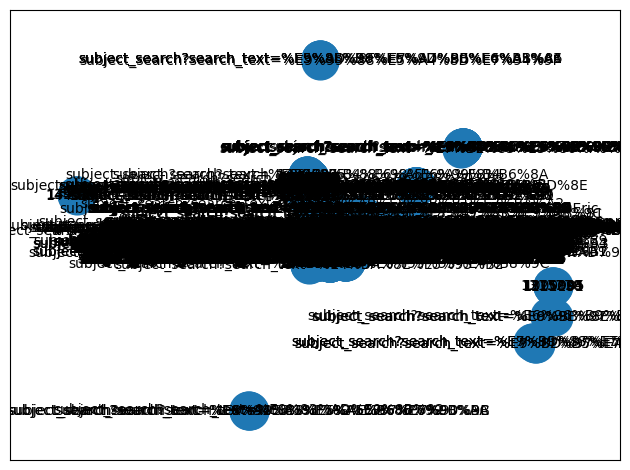

KeyboardInterrupt: 

In [39]:
plot_graph(group_like_actor_network)
plot_graph(official_like_actor_network)


In [40]:
# 计算中心性指标
def calculate_centralities(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    return degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality

def map_actors_name(top_actors):
    new_top = []
    for item in top_actors:
        (idx, score) = item
        new_top.append((idx, actor_id2name[idx], score))
    return new_top

def top_actors(centrality, n=30):
    return sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:n]

def analysis(G):
    return calculate_centralities(G)
#     # 打印前30名演员
#     for i, centrality in enumerate(['Degree', 'Betweenness', 'Closeness', 'Eigenvector']):
#         print(f"\t{centrality} Centrality Top Actors in G:")
#         for (idx, score, name) in map_actors_name(top_actors(centralities_[i])):
#             print(f'\t\t{name}\t{idx}\t{score}')

print(f'{GROUP_LIKE_LABEL} actor network analysis:')
g_central_list = analysis(group_like_actor_network)

print(f'{OFFICIAL_LIKE_LABEL} actor network analysis:')
o_central_list = analysis(official_like_actor_network)

group_like actor network analysis:
official_like actor network analysis:


In [45]:
# 最后打印两个网络的中心性结果
result_fp = open("data/centrality_result.csv", 'w')
result_fp.write(f'中心性,排名,小组偏爱演员,官方偏爱演员\n')
for i, centrality in enumerate(['Degree', 'Betweenness', 'Closeness', 'Eigenvector']):
    group_centrality = map_actors_name(top_actors(g_central_list[i]))
    official_centrality = map_actors_name(top_actors(o_central_list[i]))
    for j in range(30):
        (g_idx, g_name, g_score) = group_centrality[j]
        (o_idx, o_name, o_score) = official_centrality[j]
        result_fp.write(f'{centrality},{j+1},{g_name},{o_name}\n')
result_fp.close()

In [51]:
from statistics import mean, stdev
types = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']
def normalize_centrality(centralities):
    result = []
    for i, centrality in enumerate(types):
        centrality_normalized = {k: (v - mean(centralities[i].values())) / stdev(centralities[i].values()) for k, v in centralities[i].items()}
        result.append(centrality_normalized)
    return result
        
g_norm_central = normalize_centrality(g_central_list)
o_norm_central = normalize_centrality(o_central_list)